# Plant Diseases Classification

Цей ноутбук — відтворюваний пайплайн дослідження для задачі **binary classification** листя рослин:
- **Healthy** (здорове)
- **Sick** (хворе)

Мета:
1) побудувати сильний **baseline** на розмічених даних (Model v1),
2) виконати **pseudo-labeling** для нерозміченого пулу та повторне навчання (Model v2),
3) додати **CLIP zero-shot** baseline (без навчання),
4) провести **чесну фінальну оцінку на `/test`** (test не використовується для навчання/псевдолейблінгу/підбору порога).


## Правила експерименту та відтворюваність
- Одиниця спостереження: **1 зображення = 1 запис**.
- Позитивний клас: **sick = 1**, **healthy = 0**.
- Test-недоторканість: `/test` використовується **лише** для фінального оцінювання.
- Основна метрика для відбору чекпойнта: **F1 (на val)** + підбір порога класифікації на val.


In [ ]:
import os, random, json, shutil, hashlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms, models

from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, balanced_accuracy_score,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

def set_seed(seed=2026):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 2026
set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Завантаження даних та перевірка структури
Очікувана структура:
```
dataset_plants_final/
  train/{healthy,sick}
  val/{healthy,sick}
  test/{healthy,sick}
  unlabeled/images/
```


In [2]:
# ============================
# Paths
# ============================
DATA_DIR = Path("dataset_plants_final")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"
UNLABELED_DIR = DATA_DIR / "unlabeled" / "images"

assert TRAIN_DIR.exists() and VAL_DIR.exists() and TEST_DIR.exists(), "Не бачу train/val/test у dataset_plants_final"
assert (TRAIN_DIR/"healthy").exists() and (TRAIN_DIR/"sick").exists(), "Не бачу train/healthy та train/sick"
assert (VAL_DIR/"healthy").exists() and (VAL_DIR/"sick").exists(), "Не бачу val/healthy та val/sick"
assert (TEST_DIR/"healthy").exists() and (TEST_DIR/"sick").exists(), "Не бачу test/healthy та test/sick"
assert UNLABELED_DIR.exists(), f"Не знайдено {UNLABELED_DIR}"

Path("checkpoints").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)
Path("logs").mkdir(exist_ok=True)
Path("pseudo").mkdir(exist_ok=True)

print("✅ Paths OK")
print("TRAIN:", TRAIN_DIR.resolve())
print("VAL:", VAL_DIR.resolve())
print("TEST:", TEST_DIR.resolve())
print("UNLABELED:", UNLABELED_DIR.resolve())


✅ Paths OK
TRAIN: D:\Repos\ml_week\dataset_plants_final\train
VAL: D:\Repos\ml_week\dataset_plants_final\val
TEST: D:\Repos\ml_week\dataset_plants_final\test
UNLABELED: D:\Repos\ml_week\dataset_plants_final\unlabeled\images


## Баланс класів, пропорції, приклади
Дивимось кількість та частки класів у train/val/test. Далі — кілька прикладів зображень.

In [3]:
IMG_EXTS = {".jpg",".jpeg",".png",".bmp",".webp"}

def list_images(folder: Path):
    return [p for p in folder.rglob("*") if p.is_file() and p.suffix.lower() in IMG_EXTS]

def count_images(folder: Path) -> int:
    return len(list_images(folder))

rows = []
for split_name, split_dir in [("train", TRAIN_DIR), ("val", VAL_DIR), ("test", TEST_DIR)]:
    for cls in ["healthy", "sick"]:
        rows.append({"split": split_name, "class": cls, "count": count_images(split_dir/cls)})
df_counts = pd.DataFrame(rows)
df_counts


split    class  count
0  train  healthy    169
1  train     sick    431
2    val  healthy     58
3    val     sick    142
4   test  healthy     54
5   test     sick    146

class  healthy  sick
split               
test        54   146
train      169   431
val         58   142

class   healthy      sick
split                    
test   0.270000  0.730000
train  0.281667  0.718333
val    0.290000  0.710000

<Figure size 640x480 with 0 Axes>

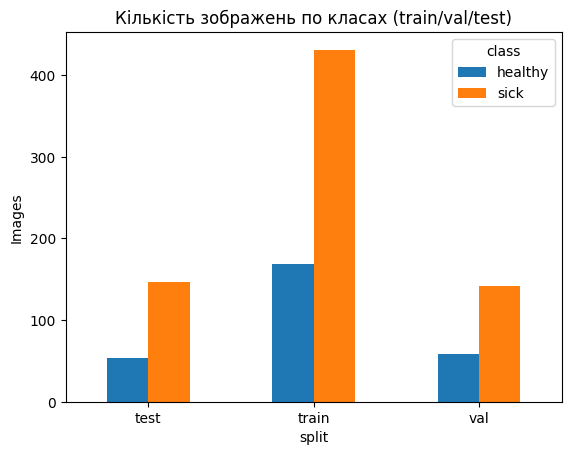

<Figure size 640x480 with 0 Axes>

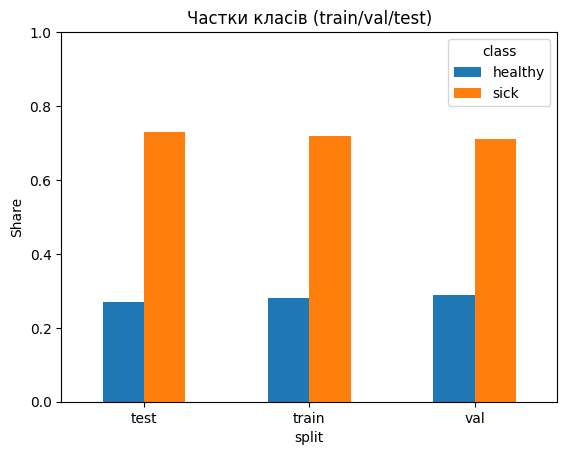

In [4]:
pivot = df_counts.pivot(index="split", columns="class", values="count").fillna(0).astype(int)
display(pivot)

# proportions
prop = pivot.div(pivot.sum(axis=1), axis=0)
display(prop)

fig = plt.figure()
pivot.plot(kind="bar")
plt.title("Кількість зображень по класах (train/val/test)")
plt.ylabel("Images")
plt.xticks(rotation=0)
plt.show()

fig = plt.figure()
prop.plot(kind="bar")
plt.title("Частки класів (train/val/test)")
plt.ylabel("Share")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()


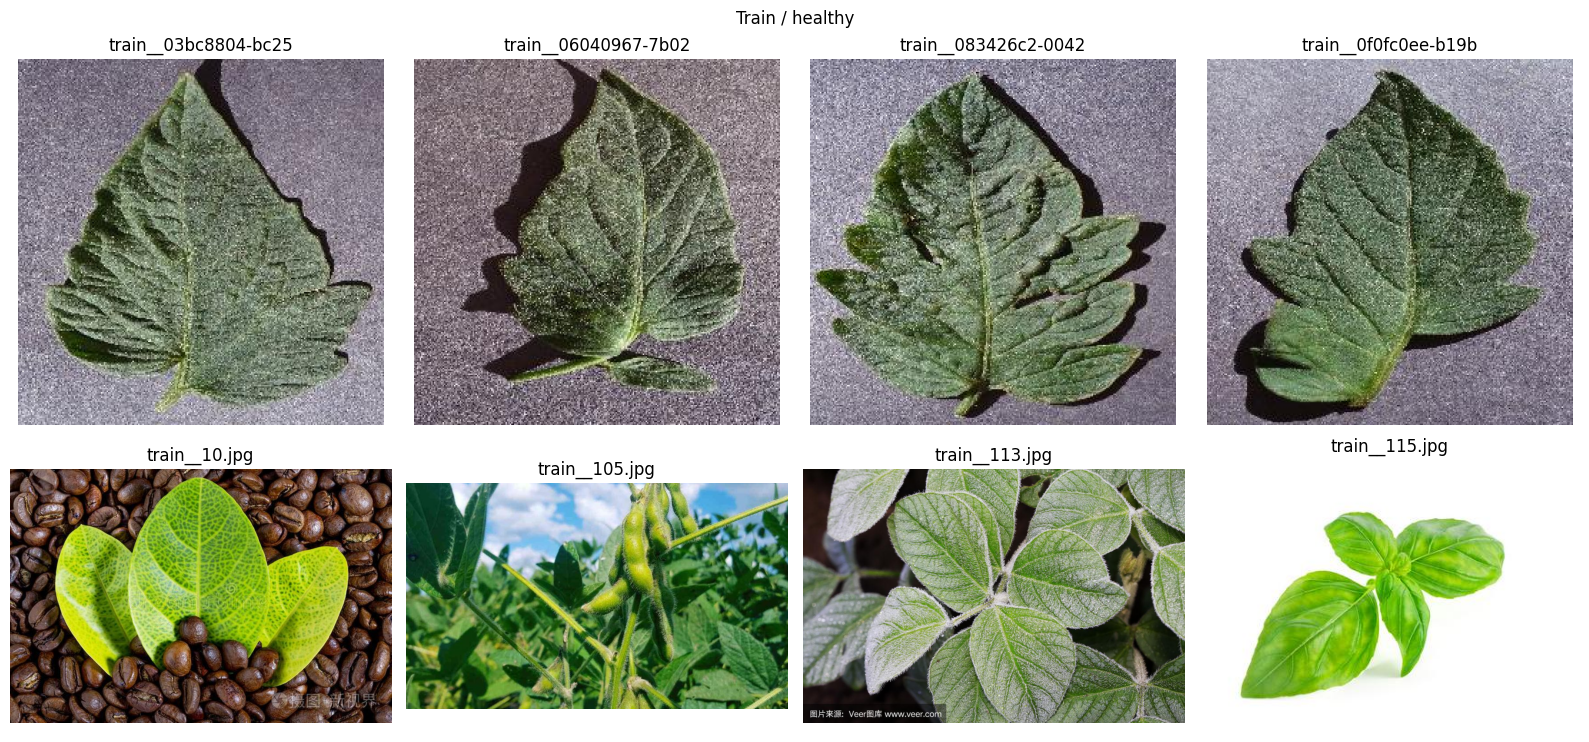

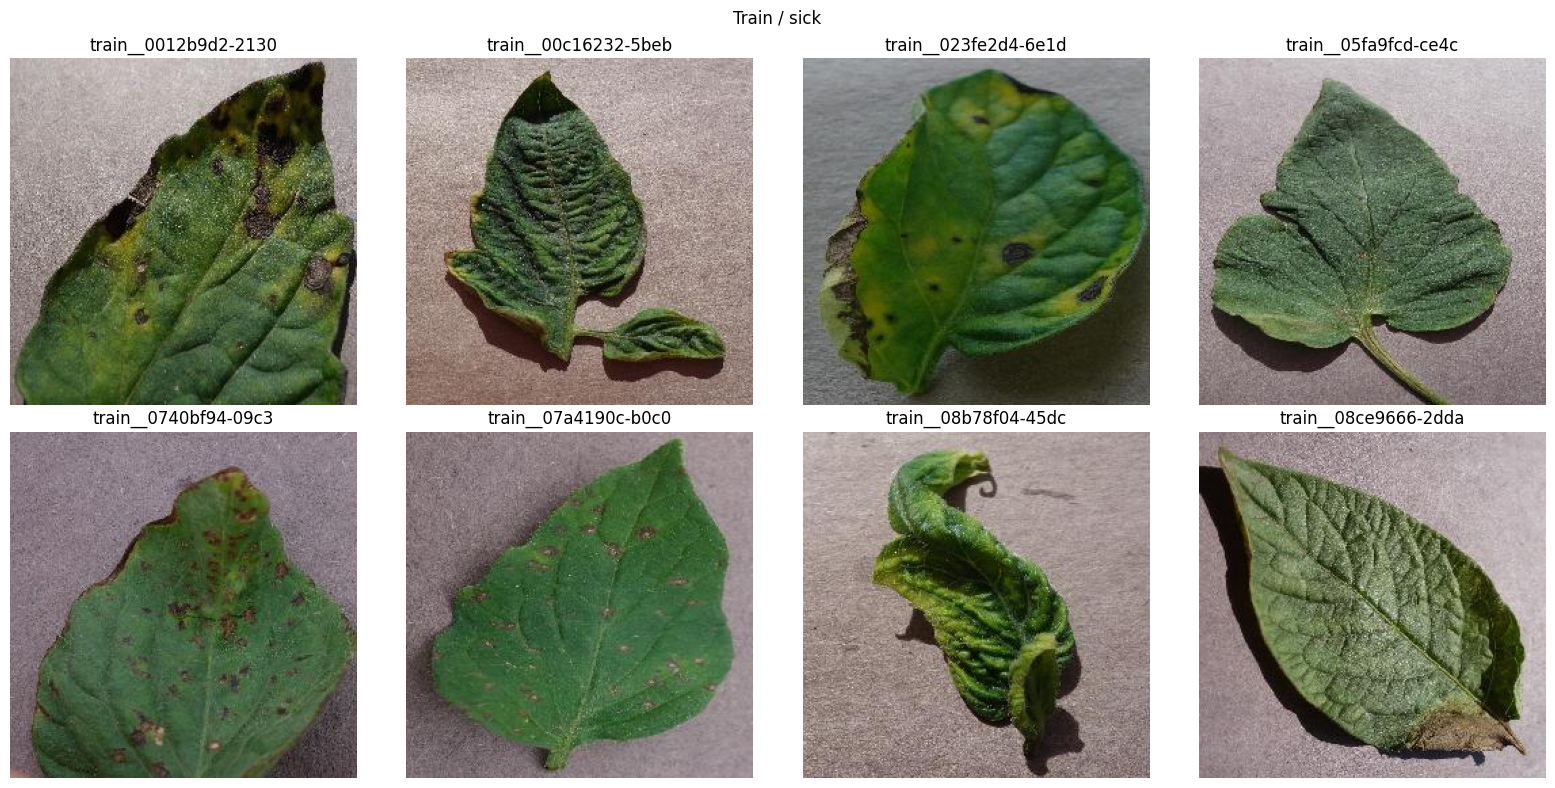

In [5]:
def show_samples(folder: Path, n=8, title=""):
    paths = list_images(folder)[:n]
    cols = min(4, len(paths))
    rows = int(np.ceil(len(paths)/cols)) if cols else 1
    plt.figure(figsize=(4*cols, 4*rows))
    for i, p in enumerate(paths, start=1):
        img = Image.open(p).convert("RGB")
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(p.name[:20])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(TRAIN_DIR/"healthy", 8, "Train / healthy")
show_samples(TRAIN_DIR/"sick", 8, "Train / sick")


Розміри зображень
Це допомагає зрозуміти, чи є різкі відмінності у розмірах/пропорціях.

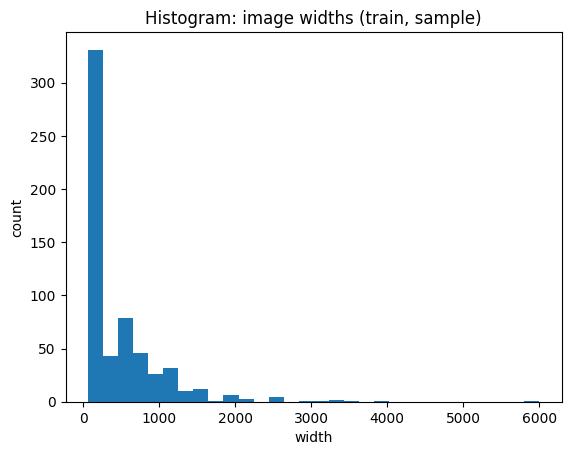

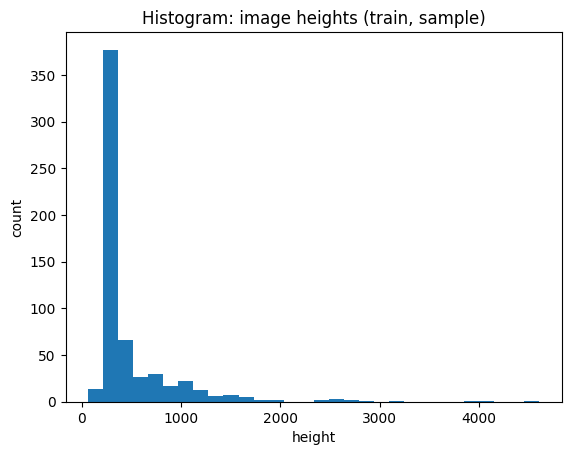

width: min/mean/max = 68 548.2516666666667 6000
height: min/mean/max = 64 490.5183333333333 4608


In [6]:
def image_size_stats(paths, max_n=400):
    paths = paths[:max_n]
    ws, hs = [], []
    for p in paths:
        try:
            img = Image.open(p)
            w, h = img.size
            ws.append(w); hs.append(h)
        except Exception:
            continue
    return np.array(ws), np.array(hs)

train_paths = list_images(TRAIN_DIR)
ws, hs = image_size_stats(train_paths, max_n=600)

plt.figure()
plt.hist(ws, bins=30)
plt.title("Histogram: image widths (train, sample)")
plt.xlabel("width"); plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(hs, bins=30)
plt.title("Histogram: image heights (train, sample)")
plt.xlabel("height"); plt.ylabel("count")
plt.show()

print("width: min/mean/max =", ws.min(), ws.mean(), ws.max())
print("height: min/mean/max =", hs.min(), hs.mean(), hs.max())


## Препроцесинг та DataLoader
- Resize до 224×224
- Normalize ImageNet
- Аугментації тільки для train

Для стабільності на різних ОС ставимо `num_workers=0`.

In [7]:
IMGSZ = 224
BATCH = 32
NUM_WORKERS = 0  # стабільно (без зависань)
PIN_MEMORY = False

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMGSZ, IMGSZ)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMGSZ, IMGSZ)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR, transform=eval_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print("class_to_idx:", train_ds.class_to_idx)
assert "sick" in train_ds.class_to_idx and "healthy" in train_ds.class_to_idx
SICK_IDX = train_ds.class_to_idx["sick"]

def to_binary(labels: torch.Tensor) -> torch.Tensor:
    # positive class = sick
    return (labels == SICK_IDX).float()


class_to_idx: {'healthy': 0, 'sick': 1}


## Model v1 (Baseline): ResNet-18 + fine-tuning
Стратегія:
- Warmup: тренуємо лише `fc`
- Fine-tune: розморожуємо `layer4 + fc` з меншим LR для backbone
- Відбір best: **F1 на val** з підбором **threshold** на val

In [8]:
# ============================
# Model + fine-tune helpers
# ============================
def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

def freeze_backbone_resnet(model):
    set_requires_grad(model, False)
    set_requires_grad(model.fc, True)

def unfreeze_resnet_layer4_plus_fc(model):
    set_requires_grad(model, False)
    set_requires_grad(model.layer4, True)
    set_requires_grad(model.fc, True)

def count_trainable_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

# class imbalance weight (train only)
n_healthy = sum(1 for _, y in train_ds.samples if y == train_ds.class_to_idx["healthy"])
n_sick    = sum(1 for _, y in train_ds.samples if y == train_ds.class_to_idx["sick"])
pos_weight = torch.tensor([ (n_healthy / max(n_sick, 1)) ], device=device, dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
print("pos_weight(sick):", float(pos_weight.item()))


pos_weight(sick): 0.3921113610267639


In [9]:
def find_best_threshold(y_true: np.ndarray, probs: np.ndarray, step=0.01):
    best_thr, best_f1 = 0.5, -1.0
    for thr in np.arange(0.05, 0.951, step):
        preds = (probs >= thr).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = float(thr)
    return best_thr, float(best_f1)

@torch.no_grad()
def eval_probs(model, loader):
    model.eval()
    all_true, all_probs = [], []
    total_loss, n = 0.0, 0

    for x, y in loader:
        x = x.to(device)
        yb = to_binary(y.to(device)).unsqueeze(1)

        logits = model(x)
        loss = criterion(logits, yb)

        probs = torch.sigmoid(logits).squeeze(1).detach().cpu().numpy()
        all_probs.append(probs)
        all_true.append(yb.squeeze(1).cpu().numpy().astype(int))

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs

    y_true = np.concatenate(all_true)
    probs = np.concatenate(all_probs)
    return float(total_loss / max(n, 1)), y_true, probs

def metrics_all(y_true: np.ndarray, probs: np.ndarray, thr: float):
    y_pred = (probs >= thr).astype(int)
    out = {
        "thr": float(thr),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist(),
    }
    if len(np.unique(y_true)) == 2:
        out["roc_auc"] = float(roc_auc_score(y_true, probs))
        out["pr_auc"] = float(average_precision_score(y_true, probs))
    else:
        out["roc_auc"] = None
        out["pr_auc"] = None
    return out

class EarlyStopping:
    def __init__(self, patience=7, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = -1e9
        self.bad = 0
    def step(self, value):
        if value > self.best + self.min_delta:
            self.best = value
            self.bad = 0
            return False
        self.bad += 1
        return self.bad >= self.patience


In [10]:
# ============================
# Training loop v1
# ============================
EPOCHS = 50
EPOCHS_WARMUP = 5
EPOCHS_FINETUNE = max(EPOCHS - EPOCHS_WARMUP, 0)

LR_HEAD = 1e-4
LR_BACKBONE = LR_HEAD * 0.1
WEIGHT_DECAY = 1e-4

USE_ONECYCLE = True
PATIENCE = 7
MIN_DELTA = 1e-4
THR_STEP = 0.01

def make_scheduler(optimizer, steps_per_epoch, epochs, max_lr):
    if USE_ONECYCLE:
        return torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=max_lr,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.1,
            div_factor=10.0,
            final_div_factor=100.0
        )
    else:
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

def train_one_epoch(model, loader, optimizer, scheduler=None):
    model.train()
    total_loss, n = 0.0, 0
    for x, y in loader:
        x = x.to(device)
        yb = to_binary(y.to(device)).unsqueeze(1)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, yb).mean()
        loss.backward()
        optimizer.step()
        if scheduler is not None and USE_ONECYCLE:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        n += bs
    return total_loss / max(n, 1)

model_v1 = models.resnet18(pretrained=True)
model_v1.fc = nn.Linear(model_v1.fc.in_features, 1)
model_v1 = model_v1.to(device)

best_f1, best_thr = -1.0, 0.5
history_v1 = []
es = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

steps_per_epoch = len(train_loader)

# Phase A: warmup fc
freeze_backbone_resnet(model_v1)
optimizer = optim.AdamW(model_v1.parameters(), lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scheduler = make_scheduler(optimizer, steps_per_epoch, EPOCHS_WARMUP, max_lr=LR_HEAD)

for ep in range(1, EPOCHS_WARMUP+1):
    tr_loss = train_one_epoch(model_v1, train_loader, optimizer, scheduler)
    val_loss, y_true, probs = eval_probs(model_v1, val_loader)
    thr, _ = find_best_threshold(y_true, probs, step=THR_STEP)
    val_m = metrics_all(y_true, probs, thr); val_m["loss"] = val_loss

    if scheduler is not None and (not USE_ONECYCLE):
        scheduler.step()

    history_v1.append({"epoch": ep, "phase":"warmup_fc", "train_loss": tr_loss, **{f"val_{k}": v for k,v in val_m.items()}})
    pd.DataFrame(history_v1).to_csv("logs/train_log_v1.csv", index=False)

    print(f"[v1 warmup] ep={ep}/{EPOCHS} tr_loss={tr_loss:.4f} val_f1={val_m['f1']:.4f} thr={thr:.2f}")

    if val_m["f1"] > best_f1:
        best_f1, best_thr = val_m["f1"], thr
        torch.save({"state_dict": model_v1.state_dict(), "best_thr": best_thr}, "checkpoints/best_model_v1.pt")
        print("✅ saved best_model_v1.pt")

    if es.step(val_m["f1"]):
        print("🛑 early stop (warmup)")
        break

# Phase B: finetune layer4+fc
if EPOCHS_FINETUNE > 0:
    unfreeze_resnet_layer4_plus_fc(model_v1)
    optimizer = optim.AdamW([
        {"params": model_v1.layer4.parameters(), "lr": LR_BACKBONE},
        {"params": model_v1.fc.parameters(), "lr": LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)

    if USE_ONECYCLE:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[LR_BACKBONE, LR_HEAD],
            epochs=EPOCHS_FINETUNE,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.1,
            div_factor=10.0,
            final_div_factor=100.0
        )
    else:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FINETUNE)

    start_ep = len(history_v1)+1
    for ep in range(start_ep, start_ep + EPOCHS_FINETUNE):
        tr_loss = train_one_epoch(model_v1, train_loader, optimizer, scheduler)
        val_loss, y_true, probs = eval_probs(model_v1, val_loader)
        thr, _ = find_best_threshold(y_true, probs, step=THR_STEP)
        val_m = metrics_all(y_true, probs, thr); val_m["loss"] = val_loss

        if scheduler is not None and (not USE_ONECYCLE):
            scheduler.step()

        history_v1.append({"epoch": ep, "phase":"finetune_layer4_fc", "train_loss": tr_loss, **{f"val_{k}": v for k,v in val_m.items()}})
        pd.DataFrame(history_v1).to_csv("logs/train_log_v1.csv", index=False)

        print(f"[v1 finetune] ep={ep}/{EPOCHS} tr_loss={tr_loss:.4f} val_f1={val_m['f1']:.4f} thr={thr:.2f}")

        if val_m["f1"] > best_f1:
            best_f1, best_thr = val_m["f1"], thr
            torch.save({"state_dict": model_v1.state_dict(), "best_thr": best_thr}, "checkpoints/best_model_v1.pt")
            print("✅ saved best_model_v1.pt")

        if es.step(val_m["f1"]):
            print("🛑 early stop (finetune)")
            break

print("🏁 v1 done. best_val_f1=", best_f1, "best_thr=", best_thr)


d:\venvs\plants-ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\venvs\plants-ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[v1 warmup] ep=1/50 tr_loss=0.4085 val_f1=0.8328 thr=0.27
✅ saved best_model_v1.pt
[v1 warmup] ep=2/50 tr_loss=0.3998 val_f1=0.8328 thr=0.28
[v1 warmup] ep=3/50 tr_loss=0.3886 val_f1=0.8353 thr=0.28
✅ saved best_model_v1.pt
[v1 warmup] ep=4/50 tr_loss=0.3914 val_f1=0.8353 thr=0.28
[v1 warmup] ep=5/50 tr_loss=0.3862 val_f1=0.8353 thr=0.29
[v1 finetune] ep=6/50 tr_loss=0.3776 val_f1=0.8328 thr=0.27
[v1 finetune] ep=7/50 tr_loss=0.3520 val_f1=0.8457 thr=0.39
✅ saved best_model_v1.pt
[v1 finetune] ep=8/50 tr_loss=0.3243 val_f1=0.8543 thr=0.44
✅ saved best_model_v1.pt
[v1 finetune] ep=9/50 tr_loss=0.2826 val_f1=0.8746 thr=0.48
✅ saved best_model_v1.pt
[v1 finetune] ep=10/50 tr_loss=0.2482 val_f1=0.8780 thr=0.43
✅ saved best_model_v1.pt
[v1 finetune] ep=11/50 tr_loss=0.2232 val_f1=0.8842 thr=0.37
✅ saved best_model_v1.pt
[v1 finetune] ep=12/50 tr_loss=0.1972 val_f1=0.8858 thr=0.33
✅ saved best_model_v1.pt
[v1 finetune] ep=13/50 tr_loss=0.1759 val_f1=0.8920 thr=0.33
✅ saved best_model_v1.pt
[

### Візуалізація навчання v1 (loss, F1)
Зчитуємо лог і малюємо криві.

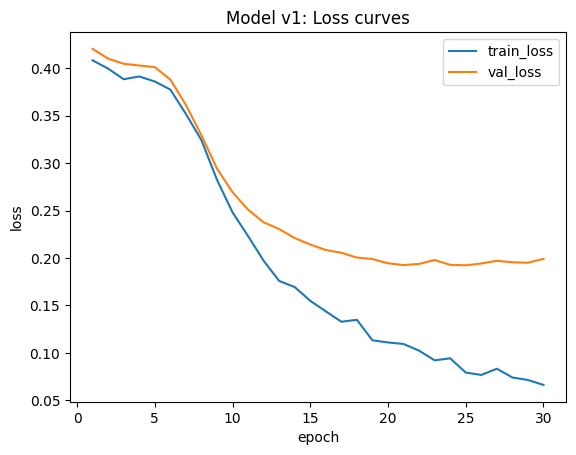

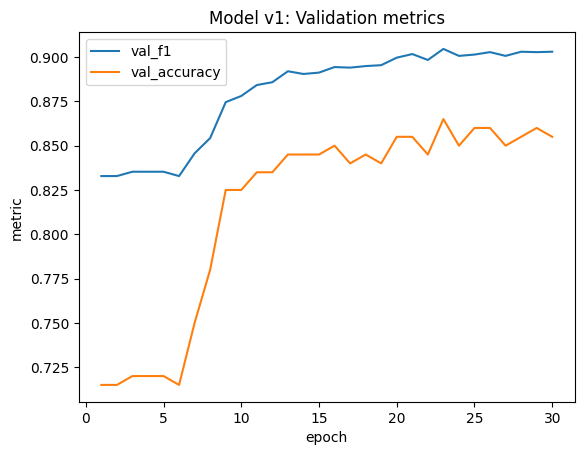

In [11]:
df1 = pd.read_csv("logs/train_log_v1.csv")
plt.figure()
plt.plot(df1["epoch"], df1["train_loss"], label="train_loss")
plt.plot(df1["epoch"], df1["val_loss"], label="val_loss")
plt.title("Model v1: Loss curves")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.show()

plt.figure()
plt.plot(df1["epoch"], df1["val_f1"], label="val_f1")
plt.plot(df1["epoch"], df1["val_accuracy"], label="val_accuracy")
plt.title("Model v1: Validation metrics")
plt.xlabel("epoch"); plt.ylabel("metric")
plt.legend(); plt.show()


## Оцінювання Model v1 на `/test` (чесно)
Test **не** використовувався для підбору порога/навчання.

In [12]:
ckpt_v1 = torch.load("checkpoints/best_model_v1.pt", map_location=device)
model_v1.load_state_dict(ckpt_v1["state_dict"])
best_thr_v1 = float(ckpt_v1.get("best_thr", 0.5))

test_loss, y_true_t, probs_t = eval_probs(model_v1, test_loader)
test_m_v1 = metrics_all(y_true_t, probs_t, best_thr_v1)
test_m_v1["loss"] = test_loss

print("TEST (Model v1):")
print(json.dumps(test_m_v1, indent=2))

with open("results/test_metrics_v1.json", "w") as f:
    json.dump(test_m_v1, f, indent=2)


C:\Users\Nazar\AppData\Local\Temp\ipykernel_25476\1195883363.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_v1 = torch.load("checkpoints/best_model_v1.pt", map_loc

TEST (Model v1):
{
  "thr": 0.39000000000000007,
  "accuracy": 0.93,
  "balanced_accuracy": 0.9170471841704718,
  "precision": 0.9583333333333334,
  "recall": 0.9452054794520548,
  "f1": 0.9517241379310345,
  "confusion_matrix": [
    [
      48,
      6
    ],
    [
      8,
      138
    ]
  ],
  "roc_auc": 0.9859208523592085,
  "pr_auc": 0.9946454624944709,
  "loss": 0.1053905326128006
}


### ROC та PR криві (Model v1, test)

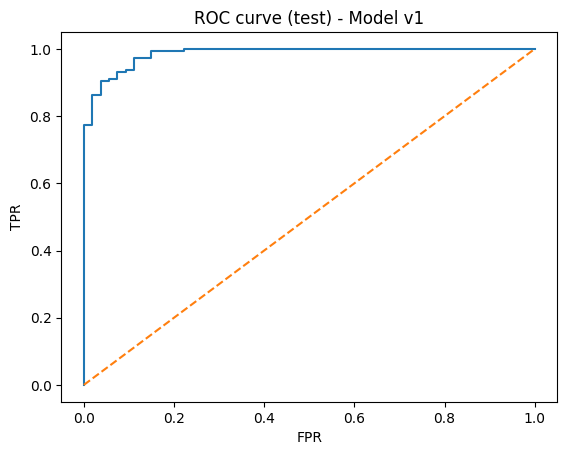

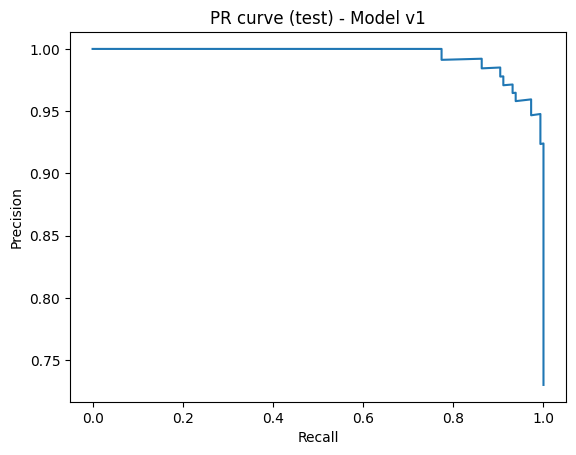

In [13]:
fpr, tpr, _ = roc_curve(y_true_t, probs_t)
prec, rec, _ = precision_recall_curve(y_true_t, probs_t)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC curve (test) - Model v1")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

plt.figure()
plt.plot(rec, prec)
plt.title("PR curve (test) - Model v1")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()


## Pseudo-labeling на `unlabeled/images`
- Прогнозуємо `p(sick)`
- `confidence = max(p, 1-p)`
- Відбір `confidence >= THRESH`
- Balanced top-K (healthy/sick)
- Перед копіюванням **чистимо** `pseudo/train` для відтворюваності.

In [14]:
THRESH = 0.90
MAX_PSEUDO_MULT = 1
BATCH_PSEUDO = 128
LIMIT_UNLABELED = None  # set small number for debug

# clean pseudo/train (reproducible)
PSEUDO_ROOT = Path("pseudo")
shutil.rmtree(PSEUDO_ROOT / "train", ignore_errors=True)
(PSEUDO_ROOT / "train" / "healthy").mkdir(parents=True, exist_ok=True)
(PSEUDO_ROOT / "train" / "sick").mkdir(parents=True, exist_ok=True)

# list unlabeled files
files = sorted([p for p in UNLABELED_DIR.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS])
if LIMIT_UNLABELED is not None:
    files = files[:LIMIT_UNLABELED]
print("unlabeled files:", len(files))

# use v1 for pseudo-labeling
pseudo_model = models.resnet18(pretrained=False)
pseudo_model.fc = nn.Linear(pseudo_model.fc.in_features, 1)
pseudo_model.load_state_dict(ckpt_v1["state_dict"])
pseudo_model = pseudo_model.to(device).eval()

rows = []
print(f"🚀 Pseudo-labeling with best_thr={best_thr_v1:.2f}, keep_conf>=THRESH={THRESH:.2f}")

bad_files = []

with torch.no_grad():
    for start in range(0, len(files), BATCH_PSEUDO):
        batch_files = files[start:start+BATCH_PSEUDO]
        xs, paths = [], []
        for fp in batch_files:
            try:
                img = Image.open(fp).convert("RGB")
                xs.append(eval_tfms(img))
                paths.append(str(fp))
            except Exception:
                bad_files.append(str(fp))

        if len(xs) == 0:
            continue

        xb = torch.stack(xs, dim=0).to(device)
        logits = pseudo_model(xb).flatten()
        p = torch.sigmoid(logits).detach().cpu().numpy()  # P(sick)

        pred = np.where(p >= best_thr_v1, "sick", "healthy")
        conf = np.maximum(p, 1.0 - p)
        keep = conf >= THRESH

        for fp, ps, pr, cf, kp in zip(paths, p, pred, conf, keep):
            rows.append((fp, float(ps), pr, float(cf), bool(kp)))

df_pseudo = pd.DataFrame(rows, columns=["path","p_sick","pred","confidence","keep"])
df_pseudo.to_csv("results/pseudo_labels_all.csv", index=False)

if bad_files:
    pd.DataFrame({"bad_path": bad_files}).to_csv("results/pseudo_bad_files.csv", index=False)
    print("⚠️ bad files saved:", len(bad_files))

df_keep = df_pseudo[df_pseudo["keep"]].copy()
df_keep.to_csv("results/pseudo_labels_selected.csv", index=False)

MAX_PSEUDO = int(len(train_ds) * MAX_PSEUDO_MULT)
k_each = MAX_PSEUDO // 2

df_sick = df_keep[df_keep["pred"] == "sick"].sort_values("confidence", ascending=False).head(k_each)
df_healthy = df_keep[df_keep["pred"] == "healthy"].sort_values("confidence", ascending=False).head(k_each)
df_bal = pd.concat([df_sick, df_healthy], axis=0)

need = MAX_PSEUDO - len(df_bal)
if need > 0:
    df_rest = df_keep.drop(df_bal.index).sort_values("confidence", ascending=False).head(need)
    df_bal = pd.concat([df_bal, df_rest], axis=0)

df_bal = df_bal.sample(frac=1.0, random_state=SEED).reset_index(drop=True)
df_bal.to_csv("results/pseudo_labels_selected_balanced_topN.csv", index=False)

print(f"✅ total={len(df_pseudo)} | passed THRESH={df_pseudo['keep'].sum()} | kept_balanced={len(df_bal)} (MAX_PSEUDO={MAX_PSEUDO})")
print(df_bal["pred"].value_counts())

def uniq_name(p: Path):
    h = hashlib.md5(str(p).encode()).hexdigest()[:10]
    return f"{p.stem}_{h}{p.suffix}"

copied = 0
for _, r in df_bal.iterrows():
    src = Path(r["path"])
    dst = PSEUDO_ROOT / "train" / r["pred"] / uniq_name(src)
    shutil.copy2(src, dst)
    copied += 1

print("✅ pseudo copied:", copied)


unlabeled files: 5000
🚀 Pseudo-labeling with best_thr=0.39, keep_conf>=THRESH=0.90


d:\venvs\plants-ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\venvs\plants-ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
d:\venvs\plants-ml\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))


✅ total=5000 | passed THRESH=2913 | kept_balanced=600 (MAX_PSEUDO=600)
pred
sick       300
healthy    300
Name: count, dtype: int64
✅ pseudo copied: 600


### Графіки для pseudo-labeling
- Гістограма confidence
- Баланс класів до/після відбору


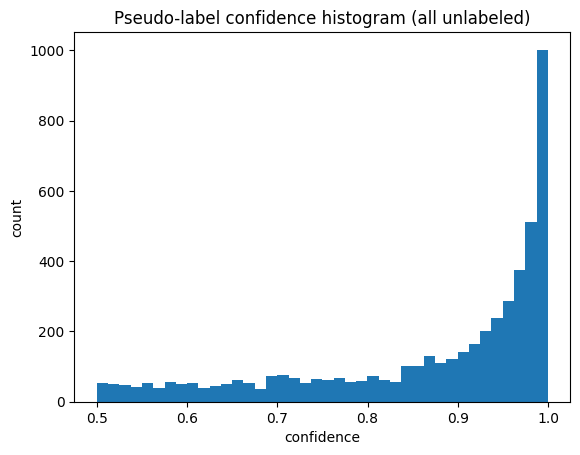

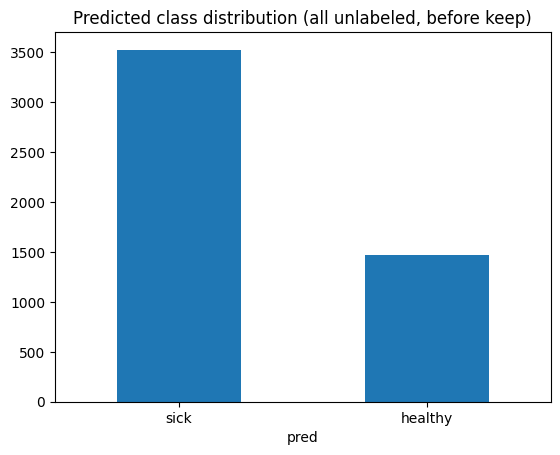

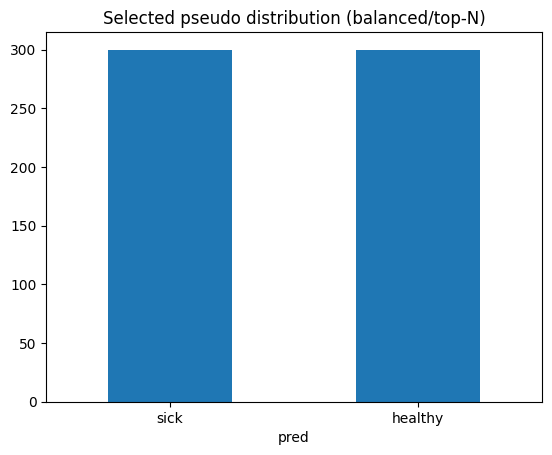

In [15]:
plt.figure()
plt.hist(df_pseudo["confidence"].values, bins=40)
plt.title("Pseudo-label confidence histogram (all unlabeled)")
plt.xlabel("confidence"); plt.ylabel("count")
plt.show()

plt.figure()
df_pseudo["pred"].value_counts().plot(kind="bar")
plt.title("Predicted class distribution (all unlabeled, before keep)")
plt.xticks(rotation=0)
plt.show()

plt.figure()
df_bal["pred"].value_counts().plot(kind="bar")
plt.title("Selected pseudo distribution (balanced/top-N)")
plt.xticks(rotation=0)
plt.show()


## Model v2: повторне навчання на (train + pseudo)
Тут використовуємо **DataLoader expanded** з `num_workers=0` (стабільно). Додатково: знижуємо вагу псевдо-прикладів через `pseudo_loss_weight`.

In [16]:
# Build pseudo dataset
pseudo_ds = datasets.ImageFolder(PSEUDO_ROOT/"train", transform=train_tfms)

class FlagDataset(Dataset):
    def __init__(self, base_ds, is_pseudo: int):
        self.base = base_ds
        self.is_pseudo = is_pseudo
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        x, y = self.base[idx]
        return x, y, torch.tensor(self.is_pseudo, dtype=torch.uint8)

labeled_flag = FlagDataset(train_ds, is_pseudo=0)
pseudo_flag  = FlagDataset(pseudo_ds, is_pseudo=1)
train_ds_expanded = ConcatDataset([labeled_flag, pseudo_flag])

train_loader_expanded = DataLoader(
    train_ds_expanded, batch_size=BATCH, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
)

print(f"✅ expanded train size: {len(train_ds_expanded)} (labeled={len(train_ds)} + pseudo={len(pseudo_ds)})")

PSEUDO_LOSS_W = 0.5

def train_one_epoch_weighted(model, loader, optimizer, scheduler=None, pseudo_weight=0.5):
    model.train()
    total_loss, n = 0.0, 0
    for x, y, is_pseudo in loader:
        x = x.to(device)
        yb = to_binary(y.to(device)).unsqueeze(1)
        is_pseudo = is_pseudo.to(device).float().view(-1,1)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        per_sample = criterion(logits, yb)  # [B,1] or scalar depending; make safe
        if per_sample.ndim == 0:
            per_sample = per_sample.view(1,1).expand_as(yb)

        w = torch.where(is_pseudo > 0.5, torch.tensor(pseudo_weight, device=device), torch.tensor(1.0, device=device))
        loss = (per_sample * w).mean()

        loss.backward()
        optimizer.step()
        if scheduler is not None and USE_ONECYCLE:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        n += bs
    return total_loss / max(n,1)


✅ expanded train size: 1200 (labeled=600 + pseudo=600)


In [17]:
# Train v2 starting from best v1 weights
model_v2 = models.resnet18(pretrained=True)
model_v2.fc = nn.Linear(model_v2.fc.in_features, 1)
model_v2 = model_v2.to(device)
model_v2.load_state_dict(ckpt_v1["state_dict"], strict=True)

EPOCHS_TOTAL_V2 = 20
EPOCHS_WARMUP_V2 = 2
EPOCHS_FINETUNE_V2 = max(EPOCHS_TOTAL_V2 - EPOCHS_WARMUP_V2, 0)

best_f1_v2, best_thr_v2 = -1.0, 0.5
history_v2 = []
es2 = EarlyStopping(patience=PATIENCE, min_delta=MIN_DELTA)

steps_per_epoch2 = len(train_loader_expanded)

# warmup fc only
freeze_backbone_resnet(model_v2)
optimizer = optim.AdamW(model_v2.parameters(), lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scheduler = make_scheduler(optimizer, steps_per_epoch2, EPOCHS_WARMUP_V2, max_lr=LR_HEAD)

for ep in range(1, EPOCHS_WARMUP_V2+1):
    tr_loss = train_one_epoch_weighted(model_v2, train_loader_expanded, optimizer, scheduler, pseudo_weight=PSEUDO_LOSS_W)

    val_loss, y_true, probs = eval_probs(model_v2, val_loader)
    thr, _ = find_best_threshold(y_true, probs, step=THR_STEP)
    val_m = metrics_all(y_true, probs, thr); val_m["loss"] = val_loss

    history_v2.append({"epoch": ep, "phase":"v2_warmup_fc", "train_loss": tr_loss, **{f"val_{k}": v for k,v in val_m.items()}})
    pd.DataFrame(history_v2).to_csv("logs/train_log_v2.csv", index=False)

    print(f"[v2 warmup] ep={ep}/{EPOCHS_TOTAL_V2} tr_loss={tr_loss:.4f} val_f1={val_m['f1']:.4f} thr={thr:.2f}")

    if val_m["f1"] > best_f1_v2:
        best_f1_v2, best_thr_v2 = val_m["f1"], thr
        torch.save({"state_dict": model_v2.state_dict(), "best_thr": best_thr_v2}, "checkpoints/best_model_v2.pt")
        print("✅ saved best_model_v2.pt")

    if es2.step(val_m["f1"]):
        print("🛑 early stop (v2 warmup)")
        break

# finetune layer4+fc
if EPOCHS_FINETUNE_V2 > 0:
    unfreeze_resnet_layer4_plus_fc(model_v2)

    optimizer = optim.AdamW([
        {"params": model_v2.layer4.parameters(), "lr": LR_BACKBONE},
        {"params": model_v2.fc.parameters(), "lr": LR_HEAD},
    ], weight_decay=WEIGHT_DECAY)

    if USE_ONECYCLE:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[LR_BACKBONE, LR_HEAD],
            epochs=EPOCHS_FINETUNE_V2,
            steps_per_epoch=steps_per_epoch2,
            pct_start=0.1,
            div_factor=10.0,
            final_div_factor=100.0
        )
    else:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_FINETUNE_V2)

    start_ep = len(history_v2)+1
    for ep in range(start_ep, start_ep + EPOCHS_FINETUNE_V2):
        tr_loss = train_one_epoch_weighted(model_v2, train_loader_expanded, optimizer, scheduler, pseudo_weight=PSEUDO_LOSS_W)

        val_loss, y_true, probs = eval_probs(model_v2, val_loader)
        thr, _ = find_best_threshold(y_true, probs, step=THR_STEP)
        val_m = metrics_all(y_true, probs, thr); val_m["loss"] = val_loss

        history_v2.append({"epoch": ep, "phase":"v2_finetune_layer4_fc", "train_loss": tr_loss, **{f"val_{k}": v for k,v in val_m.items()}})
        pd.DataFrame(history_v2).to_csv("logs/train_log_v2.csv", index=False)

        print(f"[v2 finetune] ep={ep}/{EPOCHS_TOTAL_V2} tr_loss={tr_loss:.4f} val_f1={val_m['f1']:.4f} thr={thr:.2f}")

        if val_m["f1"] > best_f1_v2:
            best_f1_v2, best_thr_v2 = val_m["f1"], thr
            torch.save({"state_dict": model_v2.state_dict(), "best_thr": best_thr_v2}, "checkpoints/best_model_v2.pt")
            print("✅ saved best_model_v2.pt")

        if es2.step(val_m["f1"]):
            print("🛑 early stop (v2 finetune)")
            break

print("🏁 v2 done. best_val_f1=", best_f1_v2, "best_thr=", best_thr_v2)


d:\venvs\plants-ml\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\venvs\plants-ml\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[v2 warmup] ep=1/20 tr_loss=0.0523 val_f1=0.9103 thr=0.20
✅ saved best_model_v2.pt
[v2 warmup] ep=2/20 tr_loss=0.0471 val_f1=0.9085 thr=0.27
[v2 finetune] ep=3/20 tr_loss=0.0478 val_f1=0.9091 thr=0.24
[v2 finetune] ep=4/20 tr_loss=0.0434 val_f1=0.9122 thr=0.20
✅ saved best_model_v2.pt
[v2 finetune] ep=5/20 tr_loss=0.0356 val_f1=0.9072 thr=0.20
[v2 finetune] ep=6/20 tr_loss=0.0386 val_f1=0.9078 thr=0.30
[v2 finetune] ep=7/20 tr_loss=0.0333 val_f1=0.9097 thr=0.20
[v2 finetune] ep=8/20 tr_loss=0.0319 val_f1=0.9155 thr=0.40
✅ saved best_model_v2.pt
[v2 finetune] ep=9/20 tr_loss=0.0261 val_f1=0.9129 thr=0.28
[v2 finetune] ep=10/20 tr_loss=0.0231 val_f1=0.9161 thr=0.35
✅ saved best_model_v2.pt
[v2 finetune] ep=11/20 tr_loss=0.0228 val_f1=0.9066 thr=0.23
[v2 finetune] ep=12/20 tr_loss=0.0289 val_f1=0.9097 thr=0.40
[v2 finetune] ep=13/20 tr_loss=0.0187 val_f1=0.9129 thr=0.25
[v2 finetune] ep=14/20 tr_loss=0.0192 val_f1=0.9193 thr=0.23
✅ saved best_model_v2.pt
[v2 finetune] ep=15/20 tr_loss=0.0

## Фінальна оцінка Model v2 на `/test` + порівняння з v1

In [18]:
ckpt_v2 = torch.load("checkpoints/best_model_v2.pt", map_location=device)
model_v2.load_state_dict(ckpt_v2["state_dict"])
best_thr_v2 = float(ckpt_v2.get("best_thr", 0.5))

test_loss2, y_true_t2, probs_t2 = eval_probs(model_v2, test_loader)
test_m_v2 = metrics_all(y_true_t2, probs_t2, best_thr_v2)
test_m_v2["loss"] = test_loss2

print("FINAL TEST (Model v2):")
print(json.dumps(test_m_v2, indent=2))

with open("results/test_metrics_v2.json", "w") as f:
    json.dump(test_m_v2, f, indent=2)

# comparison table
cmp = pd.DataFrame([
    {"model":"v1", **{k:test_m_v1.get(k) for k in ["accuracy","balanced_accuracy","precision","recall","f1","roc_auc","pr_auc","loss","thr"]}},
    {"model":"v2", **{k:test_m_v2.get(k) for k in ["accuracy","balanced_accuracy","precision","recall","f1","roc_auc","pr_auc","loss","thr"]}},
])
cmp


C:\Users\Nazar\AppData\Local\Temp\ipykernel_25476\1267351194.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_v2 = torch.load("checkpoints/best_model_v2.pt", map_loc

FINAL TEST (Model v2):
{
  "thr": 0.23000000000000004,
  "accuracy": 0.95,
  "balanced_accuracy": 0.9365804160324709,
  "precision": 0.9657534246575342,
  "recall": 0.9657534246575342,
  "f1": 0.9657534246575342,
  "confusion_matrix": [
    [
      49,
      5
    ],
    [
      5,
      141
    ]
  ],
  "roc_auc": 0.9860476915271437,
  "pr_auc": 0.9944335800896331,
  "loss": 0.0903763860464096
}


model  accuracy  balanced_accuracy  precision    recall        f1   roc_auc  \
0    v1      0.93           0.917047   0.958333  0.945205  0.951724  0.985921   
1    v2      0.95           0.936580   0.965753  0.965753  0.965753  0.986048   

     pr_auc      loss   thr  
0  0.994645  0.105391  0.39  
1  0.994434  0.090376  0.23

<Figure size 640x480 with 0 Axes>

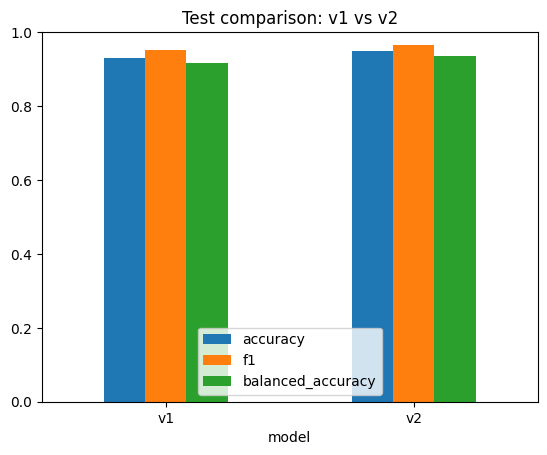

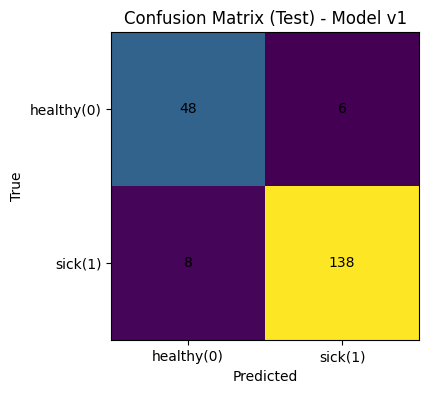

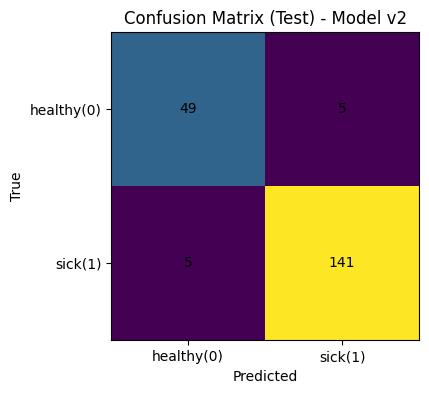

In [19]:
plt.figure()
cmp.set_index("model")[["accuracy","f1","balanced_accuracy"]].plot(kind="bar")
plt.title("Test comparison: v1 vs v2")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()

def plot_cm(cm, title):
    cm = np.array(cm)
    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.title(title)
    plt.xticks([0,1], ["healthy(0)","sick(1)"])
    plt.yticks([0,1], ["healthy(0)","sick(1)"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_cm(test_m_v1["confusion_matrix"], "Confusion Matrix (Test) - Model v1")
plot_cm(test_m_v2["confusion_matrix"], "Confusion Matrix (Test) - Model v2")


## CLIP Zero-shot baseline 
CLIP використовується **без навчання**. Порівнюємо zero-shot з CNN.

Використаємо prompt ensembling (кілька шаблонів), усереднення text embeddings.

In [ ]:
# ============================================================
# CLIP ZERO-SHOT
# ============================================================
# Якщо CLIP ще не встановлено:
# !pip -q install git+https://github.com/openai/CLIP.git

import clip
from sklearn.metrics import accuracy_score, f1_score

device_clip = "cuda" if torch.cuda.is_available() else "cpu"
print("CLIP device:", device_clip)

model_clip, preprocess_clip = clip.load("ViT-B/32", device=device_clip)
model_clip.eval()

clip_test_ds = datasets.ImageFolder(root=str(TEST_DIR), transform=preprocess_clip)
clip_loader = DataLoader(clip_test_ds, batch_size=32, shuffle=False, num_workers=0)

classes = clip_test_ds.classes
print("CLIP classes:", classes)

templates = [
    "a photo of a {} leaf",
    "a close-up photo of a {} leaf",
    "a cropped photo of a {} leaf",
    "a bright photo of a {} leaf",
    "a detailed photo of a {} plant leaf",
    "a photo of a {} crop leaf",
    "a photo of a {} leaf on a plain background",
    "a high resolution photo of a {} leaf",
]

# Encode text: mean of normalized embeddings per class
with torch.no_grad():
    class_text_features = []
    for c in classes:
        prompts = [t.format(c) for t in templates]
        tok = clip.tokenize(prompts).to(device_clip)
        tf = model_clip.encode_text(tok)
        tf = tf / tf.norm(dim=-1, keepdim=True)
        tf = tf.mean(dim=0, keepdim=True)
        tf = tf / tf.norm(dim=-1, keepdim=True)
        class_text_features.append(tf)
    text_features = torch.cat(class_text_features, dim=0)  # [C,D]

all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in clip_loader:
        images = images.to(device_clip)
        image_features = model_clip.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logits = 100.0 * image_features @ text_features.T
        probs = logits.softmax(dim=-1)
        preds = probs.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

clip_acc = accuracy_score(all_labels, all_preds)
clip_f1w = f1_score(all_labels, all_preds, average="weighted")

clip_metrics = {
    "clip_test_accuracy": float(clip_acc),
    "clip_test_f1_weighted": float(clip_f1w),
    "classes": classes,
    "templates_used": templates
}

print(json.dumps(clip_metrics, indent=2))
with open("results/clip_zeroshot_strong_test.json","w") as f:
    json.dump(clip_metrics, f, indent=2)


CLIP device: cuda
CLIP classes: ['healthy', 'sick']
{
  "clip_test_accuracy": 0.71,
  "clip_test_f1_weighted": 0.7260907944514501,
  "classes": [
    "healthy",
    "sick"
  ],
  "templates_used": [
    "a photo of a {} leaf",
    "a close-up photo of a {} leaf",
    "a cropped photo of a {} leaf",
    "a bright photo of a {} leaf",
    "a detailed photo of a {} plant leaf",
    "a photo of a {} crop leaf",
    "a photo of a {} leaf on a plain background",
    "a high resolution photo of a {} leaf"
  ]
}


## Висновки

У цій роботі було досліджено задачу бінарної класифікації зображень листя рослин із використанням як повністю контрольованого, так і напівконтрольованого підходів.

Було побудовано сильну базову модель на основі ResNet-18 з transfer learning, яка вже на обмеженому наборі розмічених даних продемонструвала високу якість узагальнення на незалежній test-вибірці.

Для подальшого покращення якості було застосовано підхід pseudo-labeling, що дозволив використати додатковий пул нерозмічених зображень. Ключовими факторами успіху стали:
- використання високого порогу впевненості для відбору псевдоміток;
- контроль балансу класів у псевдорозміченій вибірці;
- зменшена вага псевдоміток у функції втрат;
- строгий контроль недоторканості test-вибірки.

У результаті модель, навчена з використанням pseudo-labeling, продемонструвала покращення основних метрик, зокрема F1-score та recall для позитивного класу.

Додатково було проведено порівняння з CLIP у zero-shot режимі, яке показало, що без донавчання модель поступається fine-tuned CNN, що підкреслює ефективність класичного transfer learning для доменно-специфічних задач.

Загалом, результати підтверджують, що pseudo-labeling може бути ефективним інструментом, але лише за умови суворого контролю якості псевдоміток і правильно організованого експериментального процесу.
